In [1]:
%load_ext nb_black
%matplotlib inline
from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
import numpy as np
import logging
import jax


logging.getLogger().setLevel(logging.INFO)
logging.getLogger("absl").setLevel(logging.DEBUG)

set_matplotlib_formats("svg")


<IPython.core.display.Javascript object>

In [2]:
from math import log, exp
from sim import sim_and_fit, sim_wf
from estimate import sample_paths
from common import Observation
from plotting import plot_summary
rng = np.random.default_rng(2)


DEBUG:absl:Initializing backend 'interpreter'
DEBUG:absl:Initializing backend 'cpu'
DEBUG:absl:Initializing backend 'gpu'
DEBUG:absl:Error initializing backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
DEBUG:absl:Initializing backend 'tpu'
DEBUG:absl:Error initializing backend 'tpu': Invalid argument: TpuPlatform is not available.


<IPython.core.display.Javascript object>

## Various models
(Note: for technical reasons estimation currently requires genic selection. The `h` parameter can still be used to simulate non-genic selection, but `h=0.5` is assumed during inference.)

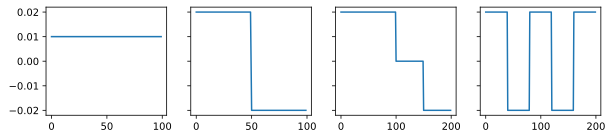

<IPython.core.display.Javascript object>

In [3]:
mdls = [
    {"s": [0.01] * 100, "h": [0.5] * 100, "f0": 0.1},
    {"s": [0.02] * 50 + [-0.02] * 50, "h": [0.5] * 100, "f0": 0.1},
    {"s": [0.02] * 100 + [0.0] * 50 + [-0.02] * 50, "h": [0.5] * 200, "f0": 0.1},
    {"s": (([0.02] * 40 + [-0.02] * 40) * 3)[:200], "h": [0.5] * 200, "f0": 0.5},
]
model = mdls[1]
for m, ax in zip(mdls, plt.subplots(ncols=len(mdls), figsize=(10, 2), sharey=True)[1]):
    ax.plot(np.arange(len(m["s"])), m["s"])

In [21]:
# Load sampling times
import pandas as pd
import tqdm

samples = pd.read_csv("aadr_1240k_EUR_4500BP_1kg_meta.txt", sep="\t")
samples["GenBP"] = samples.DateBP // 29  # assume 29 years per-generation
counts = samples.GenBP.value_counts().sort_index()
sizes, times = counts.values, np.array(counts.index)
T = times[-1]
mdl = {"s": [0.01] * T, "h": [0.5] * T, "f0": 0.1}
logging.basicConfig(level=logging.DEBUG)
logging.getLogger("estimate").setLevel(logging.INFO)
results = []

# with jax.debug_nans(True), jax.disable_jit():
for i in tqdm.trange(100):
    res1 = sim_and_fit(
        mdl,
        seed=i,
        lam=1e5,
        Ne=10000,
        k=times,
        n=sizes,
        solver_options={"ftol": 1e-4},
    )
    results.append(res1["s_hat"])

100%|██████████| 100/100 [00:20<00:00,  4.89it/s]


<IPython.core.display.Javascript object>

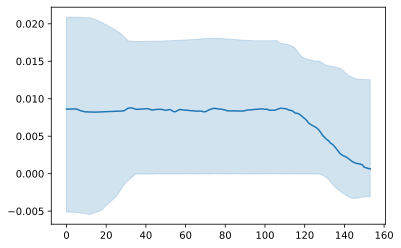

<IPython.core.display.Javascript object>

In [22]:
x = tuple(range(len(results[-1])))
plot_summary(plt.gca(), [x], results)

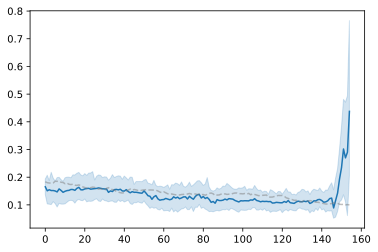

<IPython.core.display.Javascript object>

In [23]:
r = res1
from betamix import sample_paths

paths = sample_paths(r["s_hat"], r["Ne"], r["obs"], k=100, M=100)
x = tuple(range(len(r["true_af"])))
plot_summary(plt.gca(), [x], paths, r["true_af"])

In [25]:
from betamix import forward

(betas, beta0), lls = forward(r["s_hat"], r["Ne"], r["obs"], 100)

<IPython.core.display.Javascript object>